## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.   

For this project, I will be working to understand the results of an A/B test run by an e-commerce website. my goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b.The number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [8]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [7]:
df.converted.mean()*100

11.96591935560551

e. The number of times the `new_page` and `treatment` don't line up.

In [10]:
newpage_treatment_nottogether = df.query('group == "control" and landing_page == "new_page" or group == "treatment" and landing_page == "old_page"').count()
newpage_treatment_nottogether

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

In [11]:
#another way: using contingency table: 1928 + 1965 = 3893
pd.crosstab(df.landing_page, df.group)

group,control,treatment
landing_page,,
new_page,1928,145311
old_page,145274,1965


f. Do any of the rows have missing values?

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [15]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [40]:
df.shape[0] - df.dropna().shape[0]

0

**Based on  two cells above, there are no missing values in the dataset**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, I cannot be sure if this row truly received the new or old page.I will excluded the 3893 records where new_page and treatment didn't line up and will Store my new dataframe in **df2**.

In [16]:
df2 = df[((df['group']=='treatment')&(df['landing_page']=='new_page'))|((df['group']=='control')&(df['landing_page']=='old_page'))]

In [17]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Using **df2** :

a. How many unique **user_id**s are in **df2**?

In [18]:
df2.nunique()['user_id']
# or: len(df2['user_id'].unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [19]:
# display the repeated user_id
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [20]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [21]:
# No. of rows before removing the duplicate 
df2.shape[0]

290585

In [22]:
# Drop the row that belongs to the repeated user_id
df2 = df2.drop_duplicates(subset='user_id')

In [23]:
# No. of rows after removing the duplicate 
df2.shape[0]

290584

`4.` Using **df2**: 

a. What is the probability of an individual converting regardless of the page they receive?

In [24]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [27]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [28]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [34]:
#two ways:
(df2['landing_page'] == "new_page").mean(), len(df2[df2['landing_page'] == 'new_page'])/len(df2)

(0.5000619442226688, 0.5000619442226688)

e. Considering the results from a. through d. above,regarding whether I think there is sufficient evidence to say that the new treatment page leads to more conversions.

**answer:** Based on the outputs probabilities above, it seems that the connversion rate for the treatment group which is 0.1188 is slightly lower than the conversion rate for the control group which is 0.1204 ,and the probability that an individual received the new page is 0.5, however, these results don’t provide a strong and robust evidence whether one page leads to more conversions as the significance of the results and the factors that might have infeluenced the results are still unknown.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$** **:** **$p_{old}$** ≥ **$p_{new}$**

**$H_{1}$** **:** **$p_{old}$** < **$p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation. 

a. What is the **convert rate** for $p_{new}$ under the null? 

In [41]:
c_r = df2['converted'].mean()
c_r

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [42]:
# As per the instruction above, p_old = p_new = converted rate in ab_data.csv regardless of the page= c_r
c_r

0.11959708724499628

c. What is $n_{new}$?

In [38]:
#a dataframe with all new_page records from df2
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [39]:
#a dataframe with all old page records from df2
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [93]:
 new_page_converted = np.random.choice([1,0], size=n_new, p=[c_r,1-c_r])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [94]:
old_page_converted = np.random.choice([1,0], size=n_old, p=[c_r,1-c_r])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [95]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

0.0020009874160162033

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [96]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[c_r,1-c_r])
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[c_r,1-c_r])
    p_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**. 

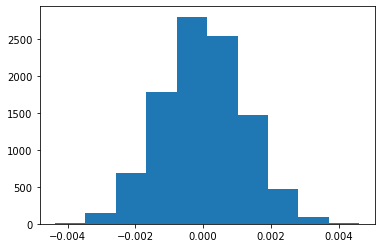

In [97]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

the plot is normally distributed, as expected

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [98]:
# Calculate the actucl difference observed in ab_data:
org_old_mean = df.query('group =="control"').converted.mean()
org_new_mean = df.query('group =="treatment"').converted.mean()
org_diff = org_new_mean - org_old_mean

# Calculate the propotion of the p_diffs are greater than the actual difference observed in ab_data.csv :
(p_diffs > org_diff).mean() 

0.8913

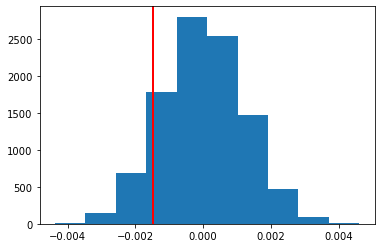

In [99]:
plt.hist(p_diffs);
plt.axvline(org_diff, color='r',linewidth = 2);

k. In words, explaining what has been just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:** The value calculated above is the P-Value ,which is the probability of observing the statistic given that the Null hypothesis is true. The P-value is 0.8913 and this is greater than the predetermined error rate alpha (0.05). Hence, we fail to reject the Null hypothesis and keep the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [100]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1').shape[0]
convert_new = df2.query('group == "treatment" & converted == 1').shape[0]
n_old = n_old
n_new = n_new

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [101]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')

z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [102]:
from scipy.stats import norm
# Assuming 95% CI for one-sided test:
norm.ppf(1-0.05)

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

 the p-value is aboout 0.905 and the critical value is 1.64, which is greater than the value of z-score 1.31. So we fail to reject the null hypothesis and keep the old page. The z-score means the test statistic is very close to the null mean, and the p-value means that there is statistical significance. The conclusion agrees with the findings in parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**A logistic regression approach is chosen here because of the binary-variables form of the conversions**

b. The goal is to use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, first we need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [103]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [104]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
...,...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [109]:
import statsmodels.api as sm
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit();

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model:

In [110]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 13 Oct 2020   Pseudo R-squ.:               8.077e-06
Time:                        17:16:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [111]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [112]:
1/np.exp(results.params)

intercept    7.306593
ab_page      1.015102
dtype: float64

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The P-Value associated with ab_page is 0.190 ,and it differs from the value found in part II because of the difference in setting the hypotheses in the two parts as the following:**

**Part II Hypotheses:**

**$H_{0}$** **:** **$p_{old}$** ≥ **$p_{new}$**

**$H_{1}$** **:** **$p_{old}$** < **$p_{new}$**

**Part III Hypotheses:**

**$H_{0}$** **:** **$p_{old}$** = **$p_{new}$**

**$H_{1}$** **:** **$p_{old}$** ≠ **$p_{new}$**

f. Now, we are considering other things that might influence whether or not an individual converts. Next is a discussion about why it is a good idea to consider other factors to add into the regression model. Are there any disadvantages to adding additional terms into the regression model?

**For more accurate decisions ,we must put into consideration other factors to understand their effects on the significance of our rsults ,but there are disadvantages appear when importing additional terms into the regression model such as multicollinearility and Simpson's paradox**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. I need to read in the **countries.csv** dataset and merge together my datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response:

In [119]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [121]:
merged_df = df2.merge(countries_df, on='user_id', how='inner')
merged_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [123]:
### Create the necessary dummy variables
final_df = merged_df.join(pd.get_dummies(merged_df['country']))
final_df.head(15)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [126]:
final_df['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [143]:
lo_mod = sm.Logit(final_df['converted'], final_df[['intercept', 'ab_page', 'CA', 'UK']])
results = lo_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 13 Oct 2020   Pseudo R-squ.:               2.323e-05
Time:                        19:30:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

The P-value above are all greater than the critical value--.05, so we should retain the null hypothesis.

In [135]:
np.exp(results.params)

CA    0.130350
UK    0.137132
dtype: float64

In [136]:
1/np.exp(results.params)

CA    7.671651
UK    7.292253
dtype: float64

In [133]:
final_df.groupby('group').mean()['converted']

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

###### conclusion:
**From the logistic regression model, the outputs didn’t seem to show a big difference in conversion rates for both groups ,and with no significant P-Value, there is no significant effect on the convertion based on the country ,so, we fail to reject the null hypothesis.**

**The practical significance of all this analysis does not seem required given that there is a small percent difference in the conversion rates between the control and treatment group from the dataset itself.**

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an **interaction between page and country** to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Providing the summary results, and the conclusions based on the results.

In [138]:
final_df['group_country'] = final_df['group'] + '_' + final_df['country']
final_df.head(15)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,group_country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,control_US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,control_US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,treatment_US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,treatment_US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,control_US
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1,control_US
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0,treatment_CA
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1,control_US
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,treatment_UK
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0,treatment_CA


In [139]:
final_df = final_df.join(pd.get_dummies(final_df['group_country']))
final_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,group_country,control_CA,control_UK,control_US,treatment_CA,treatment_UK,treatment_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,control_US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,control_US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,treatment_US,0,0,0,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,treatment_US,0,0,0,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,control_US,0,0,1,0,0,0


In [142]:
### Fit Your Linear Model And Obtain the Results
l_mod = sm.Logit(final_df['converted'], final_df[['intercept', 'ab_page', 'CA', 'UK', 'treatment_CA', 'treatment_UK']])
results = l_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 13 Oct 2020   Pseudo R-squ.:               3.482e-05
Time:                        19:28:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page         -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA              -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK              -0.0057      0.019     -0.306      0.760      -0.043       0.031
treatment_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
treatment_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
================================================================================
"""

All the p-values above are greater than the critical value, there is no significant effects on conversions between different interactions between pages.

<a id='conclusions'></a>
## Conclusions
1. All the analyses failed to reject the null hypothesis.
2. The performance of the old page was decided to be the chosen one for the company to stay with.
3. The limitation of the analysis is linked to the factors included in the data.

# Resourses

**Udacity Data Analyst Nanodegree**

**https://stackoverflow.com/**

**https://pandas.pydata.org/docs/index.html**

**https://numpy.org/doc/stable/**